## Plot data

### HectorGravelPrime

Observation dimension is 49 \
Action dimension is 6 (centroidal linear acceleration, angular acceleration)

In [243]:
import os
import pickle
import glob

# from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets
# %matplotlib widget

import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
# import torch

# Update Matplotlib's rcParams for paper-quality figures
mpl.rcParams.update({
    'font.family': 'serif',          # Use serif fonts (e.g., Times New Roman)
    'font.size': 9,                 # Base font size
    'axes.labelsize': 10,           # Font size for axis labels
    'axes.titlesize': 10,           # Font size for titles
    'xtick.labelsize': 8,           # Font size for x-axis tick labels
    'ytick.labelsize': 8,           # Font size for y-axis tick labels
    'legend.fontsize': 8,           # Font size for legend text
    'text.usetex': False,           # Use TeX for rendering text (set True for high-quality LaTeX output)
    'figure.dpi': 300,              # Higher resolution for publication
    'savefig.dpi': 300,             # Ensure saved figures have high resolution/home/jkamohara3/hector/IsaacLab/scripts/biped/plot
    'figure.figsize': (3.5, 2.5),   # Set figure size to match journal column width
    'axes.linewidth': 0.8,          # Thinner axis lines for a clean look
    'legend.frameon': False,         # Remove the legend frame for a cleaner appearance
    'lines.linewidth': 1.0          # Thinner plot lines for a clean look
}) 

In [244]:
def quaternion_to_euler(quats):
    """
    Convert a batch of quaternions to Euler angles (roll, pitch, yaw) using only NumPy.
    
    Parameters:
        quats (numpy.ndarray): Shape (batch_size, 4), where each row is [x, y, z, w]
    
    Returns:
        numpy.ndarray: Shape (batch_size, 3), where each row is [roll, pitch, yaw] in radians
    """
    w = quats[:, 0]
    x = quats[:, 1]
    y = quats[:, 2]
    z = quats[:, 3]

    # Roll (x-axis rotation)
    sinr_cosp = 2 * (w * x + y * z)
    cosr_cosp = 1 - 2 * (x * x + y * y)
    roll = np.arctan2(sinr_cosp, cosr_cosp)

    # Pitch (y-axis rotation)
    sinp = 2 * (w * y - z * x)
    pitch = np.where(np.abs(sinp) >= 1, np.sign(sinp) * np.pi / 2, np.arcsin(sinp))  # Handle gimbal lock

    # Yaw (z-axis rotation)
    siny_cosp = 2 * (w * z + x * y)
    cosy_cosp = 1 - 2 * (y * y + z * z)
    yaw = np.arctan2(siny_cosp, cosy_cosp)
    
    # normalize to -pi to pi
    roll = np.arctan2(np.sin(roll), np.cos(roll))
    pitch = np.arctan2(np.sin(pitch), np.cos(pitch))
    yaw = np.arctan2(np.sin(yaw), np.cos(yaw))

    return np.stack([roll, pitch, yaw], axis=1)  # Shape (batch_size, 3)

def cluster_time_points(t_array, threshold=0.01):
    """
    Groups time points into chunks if they are within `threshold` seconds apart.
    Returns a list of (start_time, end_time) for each chunk.
    """
    if len(t_array) == 0:
        return []

    t_array = np.sort(t_array)
    chunks = []
    start = t_array[0]
    end = t_array[0]

    for t in t_array[1:]:
        if t - end <= threshold:
            end = t  # extend current chunk
        else:
            chunks.append((start, end))
            start = t
            end = t
    chunks.append((start, end))  # don't forget the last one
    return chunks

In [245]:
# data folder
# data_root = "../logs/Hector-Hierarchical-Prime-Full3-Rigid/2025-04-09_18-28-24/logs/mpc"
# data_root = "/home/jkamohara3/hector/isaac4.5/IsaacLab4.5/logs/rl_games/ppo_rl_games_stepping_stone_mlp/2025-04-17_18-23-54/logs/rl"
# data_root = "/home/jkamohara3/hector/isaac4.5/IsaacLab4.5/logs/rl_games/ppo_rl_games_stepping_stone_mlp/2025-04-18_02-06-50/logs/rl"
# data_root = "/home/jkamohara3/hector/isaac4.5/IsaacLab4.5/logs/rl_games/manager_ppo_rl_games_stepping_stone_mlp/2025-04-26_02-35-21/logs/rl"
# data_root = "/home/jkamohara3/hector_ws/isaac_45/IsaacLab4.5/logs/rl_games/manager_ppo_rl_games_stepping_stone_mlp/2025-04-28_16-52-00/logs/rl"

# data_root = "/home/jkamohara3/hector/isaac4.5/IsaacLab4.5/logs/rl_games/manager_ppo_rl_games_stepping_stone_mlp/2025-04-29_02-17-55/logs/mpc"
# data_root = "/home/jkamohara3/hector/isaac4.5/IsaacLab4.5/logs/rl_games/manager_ppo_rl_games_stepping_stone_mlp/2025-04-29_02-17-55/logs/rl"

# data_root = "/home/jkamohara3/hector/isaac4.5/IsaacLab4.5/logs/rl_games/manager_ppo_rl_games_stepping_stone_mlp/2025-04-30_02-19-23/logs/play_rl"

# data_root = "/home/jkamohara3/hector/isaac4.5/IsaacLab4.5/logs/rl_games/manager_sac_rl_games_stepping_stone_mlp/2025-05-02_17-54-51/logs/play_rl"

# data_root = "/home/jkamohara3/hector/isaac4.5/IsaacLab4.5/logs/rl_games/manager_sac_rl_games_stepping_stone_mlp/2025-05-04_19-19-02/logs/play_rl_0.12m"
data_root = "/home/jkamohara3/hector/isaac4.5/IsaacLab4.5/logs/rl_games/manager_sac_rl_games_stepping_stone_mlp/2025-05-04_19-19-02/logs/play_rl_0.1m"
# data_root = "/home/jkamohara3/hector/isaac4.5/IsaacLab4.5/logs/rl_games/manager_sac_rl_games_stepping_stone_mlp/2025-05-04_19-19-02/logs/play_rl_0.08m"
# data_root = "/home/jkamohara3/hector/isaac4.5/IsaacLab4.5/logs/rl_games/manager_sac_rl_games_stepping_stone_mlp/2025-05-04_19-19-02/logs/play_rl_0.06m"

In [246]:
state_dir = os.path.join(data_root, "state")
obs_dir = os.path.join(data_root, "obs")
action_dir = os.path.join(data_root, "action")
episode_length_dir = os.path.join(data_root, "episode")

# collect all the data
state_files = glob.glob(os.path.join(state_dir, "*.pkl"))
obs_files = glob.glob(os.path.join(obs_dir, "*.pkl"))
action_files = glob.glob(os.path.join(action_dir, "*.pkl"))
episode_files = glob.glob(os.path.join(episode_length_dir, "*.pkl"))


# sort the files
state_files.sort()
obs_files.sort()
action_files.sort()
episode_files.sort()

# load the data
for i in range(len(state_files)):
    state_file = state_files[i]
    obs_file = obs_files[i]
    action_file = action_files[i]
    episode_file = episode_files[i]

    with open(state_file, "rb") as f:
        state = pickle.load(f)
    with open(obs_file, "rb") as f:
        obs = pickle.load(f)
    with open(action_file, "rb") as f:
        action = pickle.load(f)
    with open(episode_file, "rb") as f:
        episode_length_data = pickle.load(f)

state_data = np.array(state)
obs_data = np.array(obs)
action_data = np.array(action)
mpc_action_data = obs_data[:, :, :, 50:56]
episode_length_data = np.array(episode_length_data)

episode_length = state_data.shape[0]
batch_size = state_data.shape[1]
time_step = state_data.shape[2]

state_data = state_data.reshape(episode_length*batch_size, time_step, -1)

# time step
num_history = 1
height_w, height_h = 11, 11
height_scan_num = height_w * height_h
obs_data = obs_data.reshape(episode_length*batch_size, time_step, -1)
height_data = obs_data[:, :, -height_scan_num:]
obs_data = obs_data[:, :, :-height_scan_num].reshape(episode_length*batch_size, time_step, num_history, -1)[:, :, -1, :]
action_data = action_data.reshape(episode_length*batch_size, time_step, -1)
mpc_action_data = mpc_action_data.reshape(episode_length*batch_size, time_step, -1)
episode_length_data = episode_length_data.reshape(-1)


num_envs = obs_data.shape[0]
print("==== baseline mpc ====")
print("number of envs: ", obs_data.shape[0])
print("state dimension: ", state_data.shape)
print("observersation dimension: ", obs_data.shape)
print("action dimension: ", action_data.shape)

==== baseline mpc ====
number of envs:  20
state dimension:  (20, 2000, 33)
observersation dimension:  (20, 2000, 64)
action dimension:  (20, 2000, 3)


In [247]:
# t = 250
# height = height_data[0][t].reshape(height_h, height_w)
# # 3D plot
# fig = plt.figure(figsize=(5, 2))
# ax = fig.add_subplot(111, projection='3d')
# x = np.linspace(-0.25, 0.25, height_w)
# y = np.linspace(-0.25, 0.25, height_h)
# X, Y = np.meshgrid(x, y)

# ax.plot_surface(X, Y, height, cmap='viridis', edgecolor='none')
# ax.set_xlabel('X-axis')
# ax.set_ylabel('Y-axis')
# ax.set_zlabel('Height')
# ax.set_title('3D Surface Plot')

# # plt.tight_layout()
# plt.axis('equal')  # Comment out for 3D
# plt.show()

In [248]:
dt_policy = 0.01

# observation indices
height_indies = 0
linear_velocity_indies = slice(1, 4)
angular_velocity_indies = 6
orientation_indies = slice(7, 10)
desired_linear_velocity_indies = slice(10, 12)
desired_angular_velocity_indies = 12
joint_pos_indies = slice(13, 23)
joint_vel_indies = slice(23, 33)
jont_effort_indices = slice(33, 43)

# mpc state
swing_phase_indices = slice(43, 45)
foot_placement_b_indices = slice(45, 49)
foot_position_b_indices = slice(49, 55)
reference_foot_position_b_indices = slice(55, 61)

# action
action_indices = slice(61, 64)

mpc_action_indices = slice(44, 50)
gait_contact_indices = slice(50, 52)
swing_phase_indices = slice(52, 54)
raibert_fps_indices = slice(54, 58)
augmented_fps_indices = slice(58, 62)
previous_action_indices = slice(62, 82)

# extract data
velocity_x = obs_data[:, :, linear_velocity_indies][:, :, 0]
desired_velocity_x = obs_data[:, :, desired_linear_velocity_indies][:, :, 0]
ang_velocity = obs_data[:, :, angular_velocity_indies]
desired_ang_velocity = obs_data[:, :, desired_angular_velocity_indies]

joint_pos = obs_data[:, :, joint_pos_indies]
joint_vel = obs_data[:, :, joint_vel_indies]
joint_effort = obs_data[:, :, jont_effort_indices]

swing_phase = obs_data[:, :, swing_phase_indices]
foot_placement_b = obs_data[:, :, foot_placement_b_indices]
foot_position_b = obs_data[:, :, foot_position_b_indices].reshape(num_envs, -1, 2, 3)
reference_foot_position_b = obs_data[:, :, reference_foot_position_b_indices]

# state indices
state_position_indices = slice(0, 3)
state_quat_indices = slice(3, 7)
velocity_indices = slice(7, 10)
ang_velocity_indices = slice(10, 13)

position = state_data[:, :, state_position_indices]
quat = state_data[:, :, state_quat_indices]
euler = (180/np.pi) * quaternion_to_euler(quat.reshape(-1, 4)).reshape(num_envs, -1, 3)
velocity = state_data[:, :, velocity_indices]
ang_velocity = state_data[:, :, ang_velocity_indices]

position_des = np.zeros_like(state_data[:, :, state_position_indices])
orientation_des = np.zeros_like(state_data[:, :, state_position_indices])

orientation_des[:, :, 2] = np.cumsum(desired_ang_velocity*dt_policy, axis=1)
orientation_des[:, :, 2] = np.arctan2(np.sin(orientation_des[:, :, 2]), np.cos(orientation_des[:, :, 2]))

position_des[:, :, 0] = np.cumsum(desired_velocity_x*np.cos(orientation_des[:, :, 2])*dt_policy, axis=1)
position_des[:, :, 1] = np.cumsum(desired_velocity_x*np.sin(orientation_des[:, :, 2])*dt_policy, axis=1)
position_des[:, :, 2] = 0.55 * np.ones_like(position_des[:, :, 2])

# change to deg
orientation_des = (180/np.pi) * orientation_des

# to world frame
foot_position_w = foot_position_b + position[:, :, None, :]

## Action check

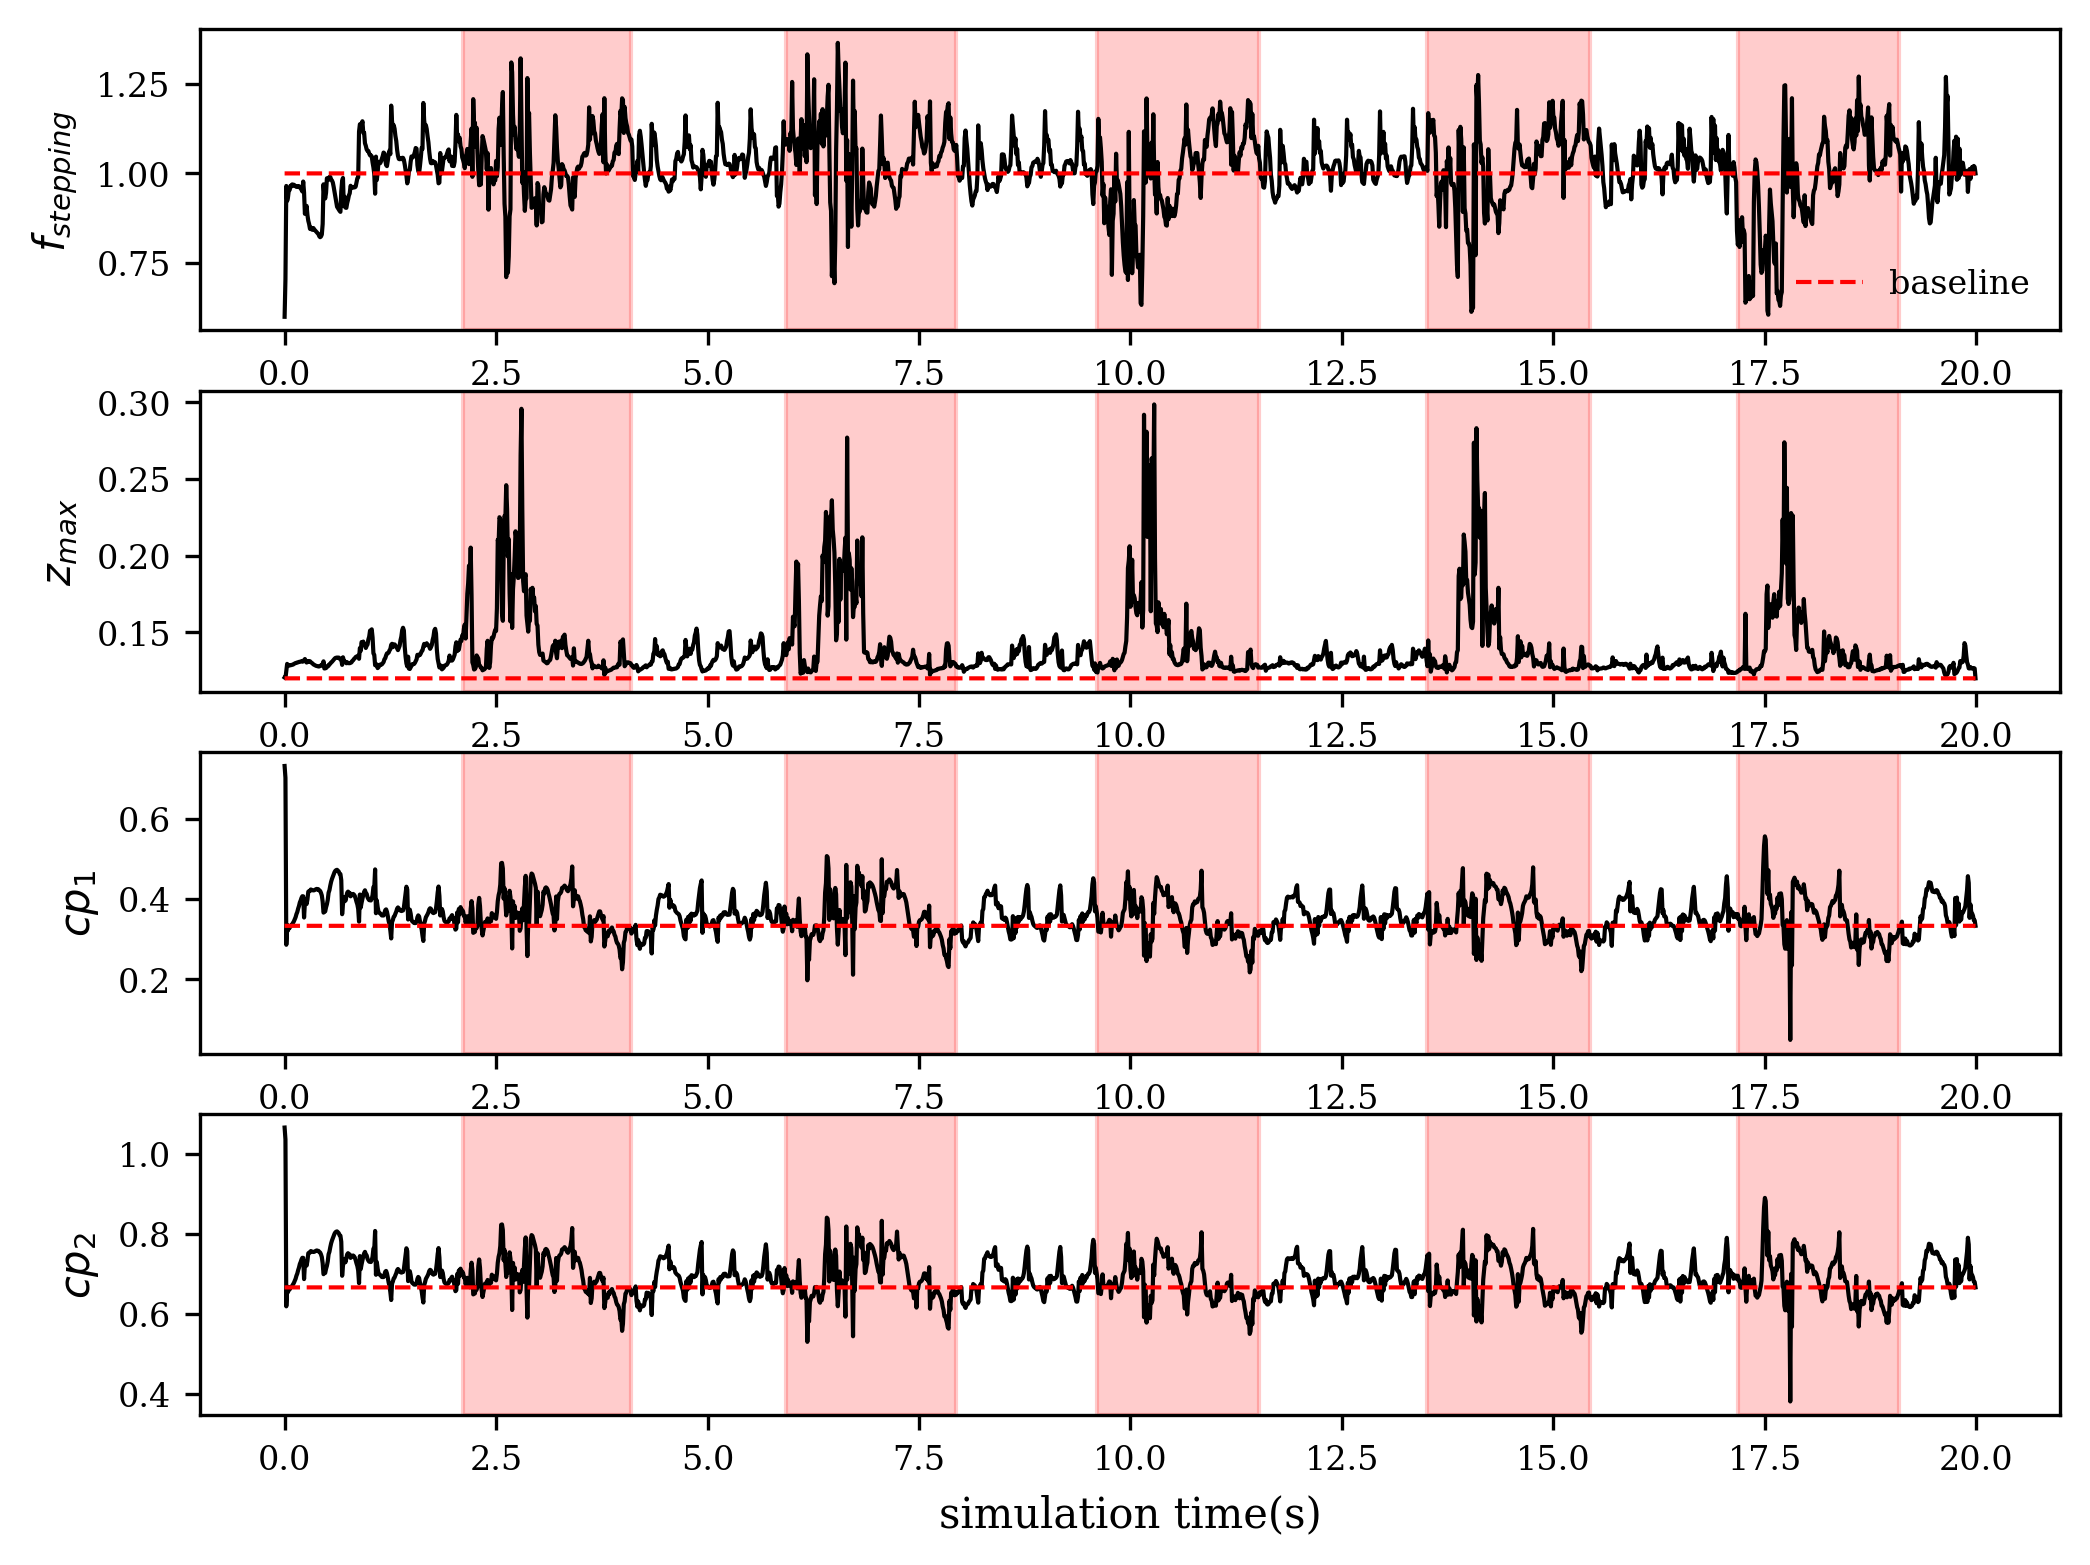

In [241]:
from copy import copy
plt.figure(figsize=(8, 6))
use_moving_average = False
filter_size = 2

cut_off_time = int(20.0*100)
num_sample = 1
for i in range(num_sample): 
    i = 0
    
    # detect stepping stone
    window_size = 3
    height_patch = height_data[i].reshape(-1, height_w, height_h)
    height_patch = height_patch[:, (height_h+1)//2-window_size:(height_h+1)//2+window_size+1, (height_w+1)//2-window_size:(height_w+1)//2+window_size+1].reshape(height_data[i].shape[0], -1)
    flatness = height_patch.max(axis=1) - height_patch.min(axis=1)
    t_rough = (1/100) * np.where(flatness > 5e-2)[0]
    t_chunks = cluster_time_points(t_rough, threshold=0.1)[:-1]

    t = (1/100) * np.arange(action_data[i].shape[0]) 
    if not use_moving_average:
        a = copy(action_data[i])
    else:
        a = copy(action_data[i])
        for n in range(6):
            tmp = np.convolve(a[:, n], np.ones((filter_size))/filter_size, mode='valid')
            a[:, n] = np.concatenate([tmp, np.tile(tmp[-1], (len(action_data[i]) - len(tmp)))], axis=0)
    
    num_traj = 4
    plt.subplot(4, 1, 1)
    plt.plot(t[:cut_off_time], 1.0+a[:, 0][:cut_off_time], color="k")
    plt.plot(t[:cut_off_time], 1.0*np.ones_like(a[:, 0]), label="baseline", color="r", linestyle="--")
    for t_start, t_end in t_chunks:
        plt.axvspan(t_start, t_end, color='red', alpha=0.2)
    plt.ylabel(r"$f_{stepping}$")
    plt.legend(loc="lower right")
    
    plt.subplot(4, 1, 2)
    plt.plot(t[:cut_off_time], 0.12+a[:, 1][:cut_off_time], label=r"$z_max$", color="k")
    plt.plot(t[:cut_off_time], 0.12*np.ones_like(a[:, 1]), label="z_b", color="r", linestyle="--")
    for t_start, t_end in t_chunks:
        plt.axvspan(t_start, t_end, color='red', alpha=0.2)
    plt.ylabel(r"$z_{max}$")
    
    plt.subplot(4, 1, 3)
    plt.plot(t[:cut_off_time], 1/3+a[:, 2][:cut_off_time], label=r"$cp_1$", color="k")
    plt.plot(t[:cut_off_time], (1/3)*np.ones_like(a[:, 2]), label="cp1_b", color="r", linestyle="--")
    for t_start, t_end in t_chunks:
        plt.axvspan(t_start, t_end, color='red', alpha=0.2)
    plt.ylabel(r"$cp_1$")
    
    plt.subplot(4, 1, 4)
    plt.plot(t[:cut_off_time], 2/3+a[:, 2][:cut_off_time], label=r"$cp_2$", color="k")
    plt.plot(t[:cut_off_time], (2/3)*np.ones_like(a[:, 2]), label="cp2_b", color="r", linestyle="--")
    for t_start, t_end in t_chunks:
        plt.axvspan(t_start, t_end, color='red', alpha=0.2)
    plt.xlabel("simulation time(s)")
    plt.ylabel(r"$cp_2$")

plt.savefig("action_data_0.06m.png")

plt.show()

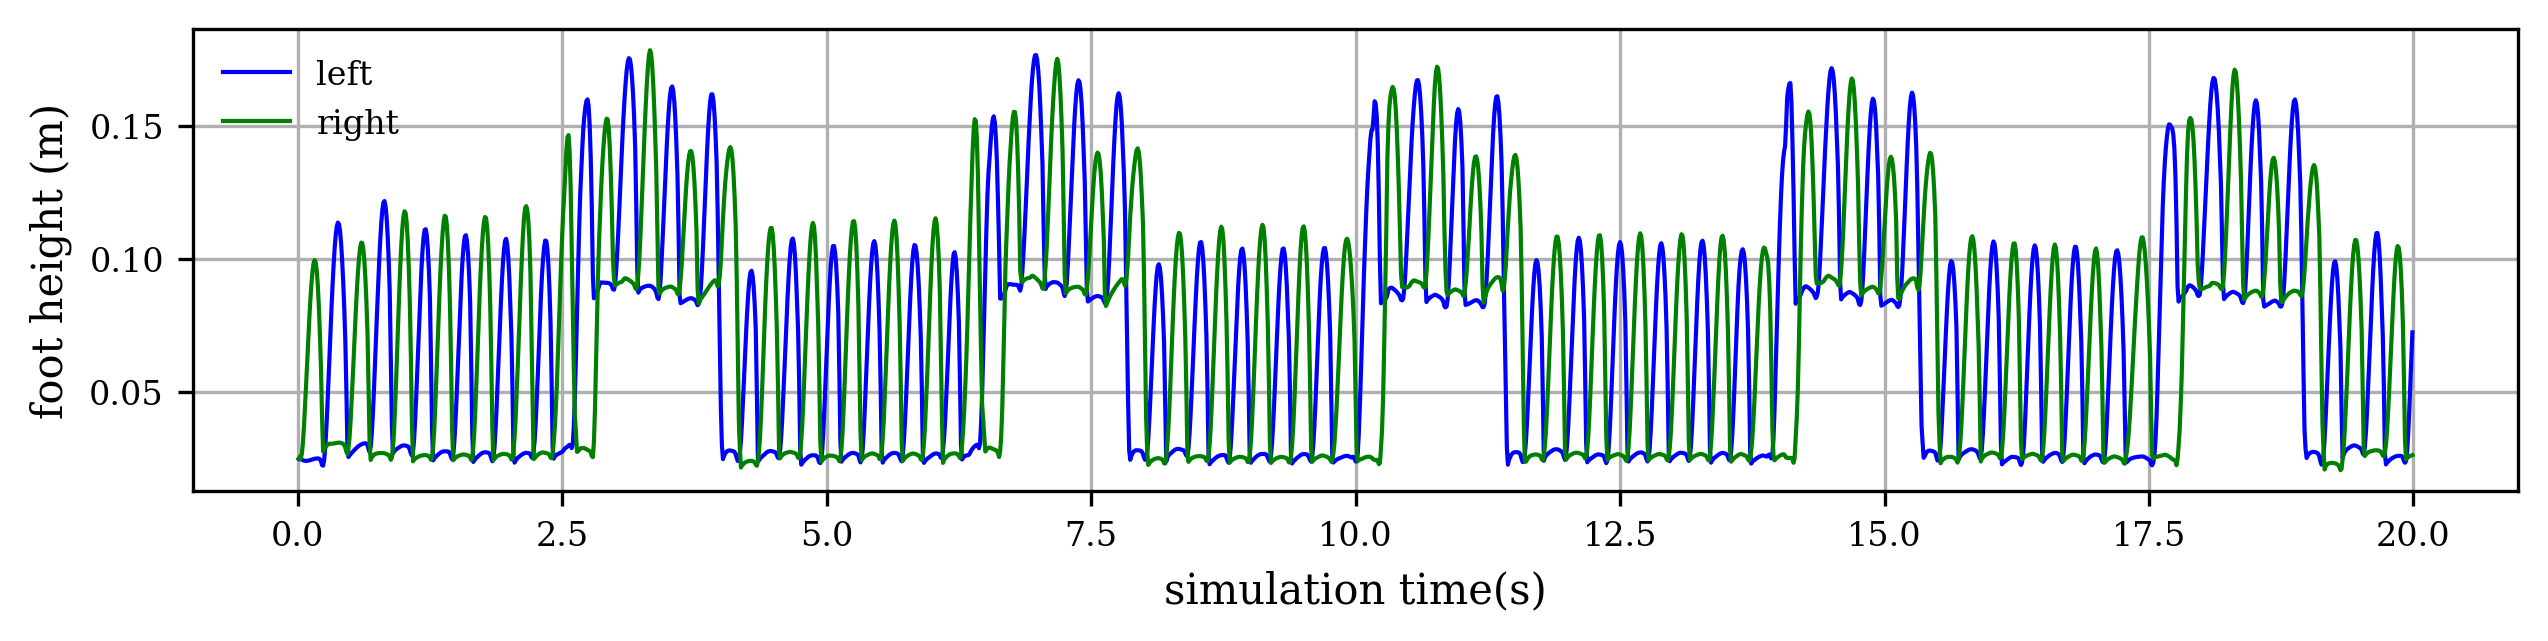

In [242]:
plt.figure(figsize=(10, 2))

i = 0
t = (1/100) * np.arange(foot_position_w[i].shape[0])
plt.plot(t[1:], foot_position_w[i][1:, 0, -1], c="b", label="left")
plt.plot(t[1:], foot_position_w[i][1:, 1, -1], c="g", label="right")
plt.grid()
plt.xlabel("simulation time(s)")
plt.ylabel("foot height (m)")
plt.legend()
plt.savefig("foot_height_0.06m.png")
plt.show()

## Observation check

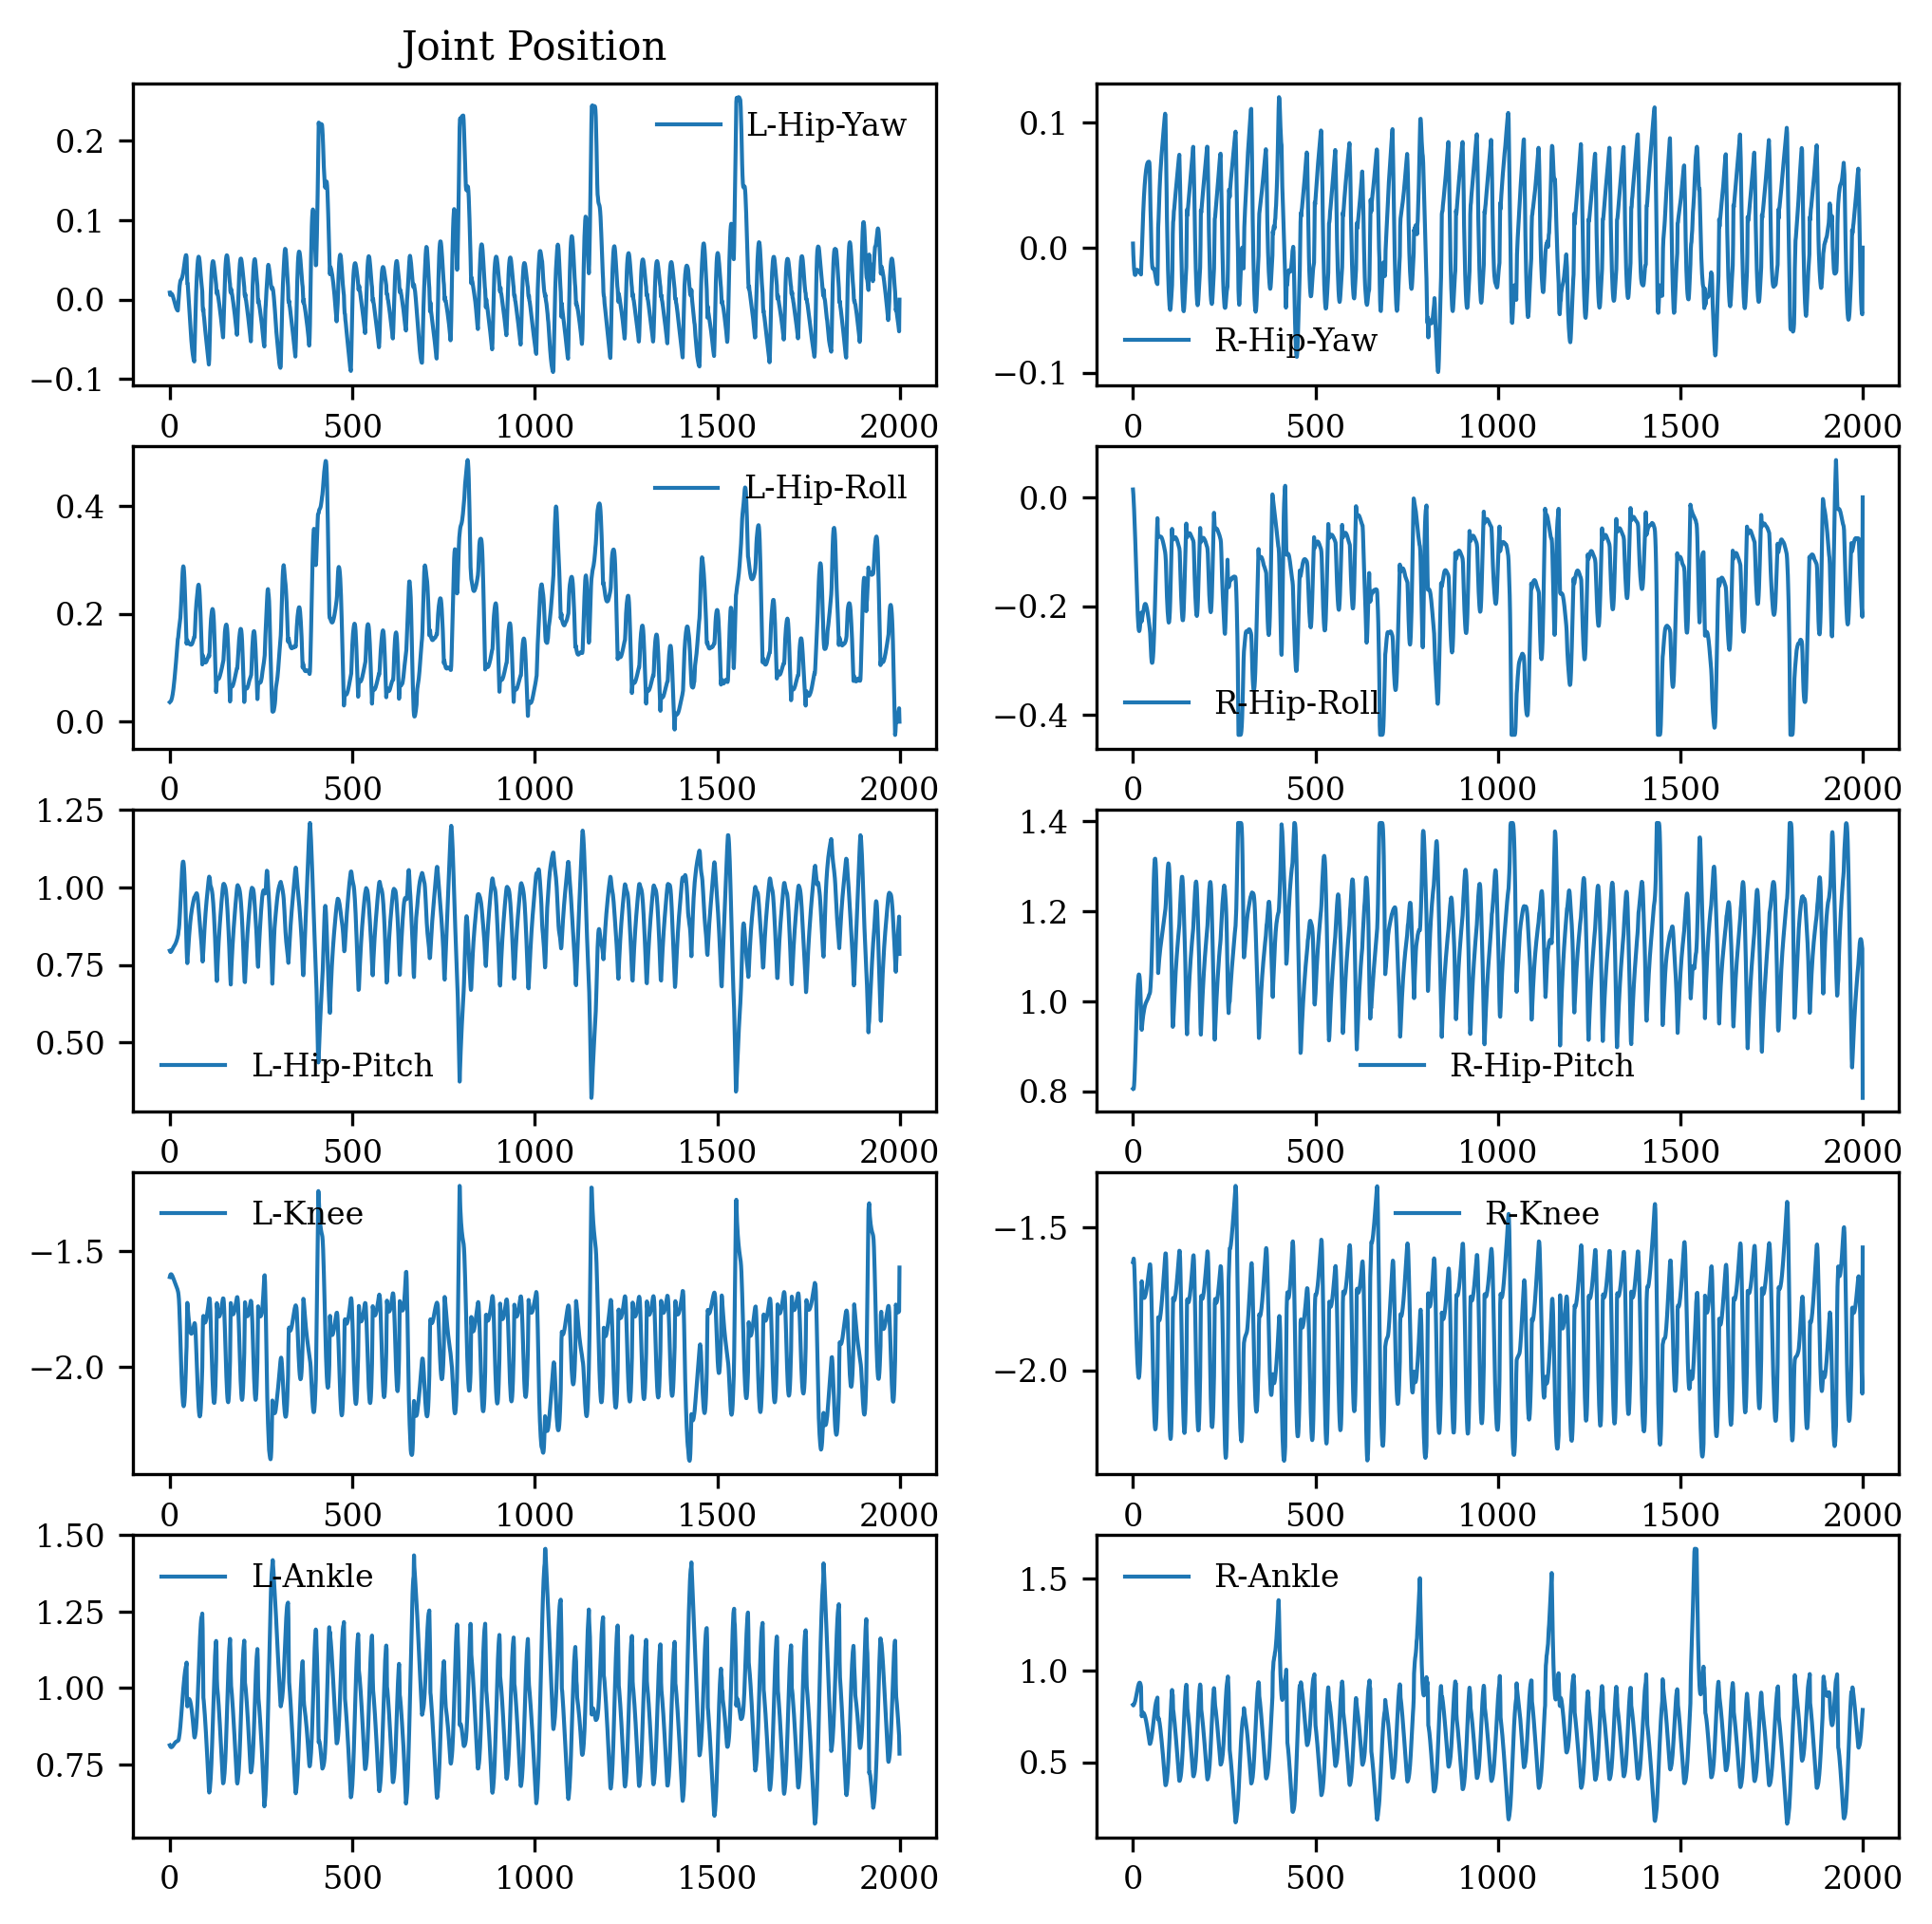

In [123]:
plt.figure(figsize=(8, 8))

plt.subplot(5, 2, 1)
plt.plot(joint_pos[0, :, 0], label="L-Hip-Yaw")
plt.title("Joint Position")
plt.legend()

plt.subplot(5, 2, 2)
plt.plot(joint_pos[0, :, 5], label="R-Hip-Yaw")
plt.legend()

plt.subplot(5, 2, 3)
plt.plot(joint_pos[0, :, 1], label="L-Hip-Roll")
plt.legend()

plt.subplot(5, 2, 4)
plt.plot(joint_pos[0, :, 6], label="R-Hip-Roll")
plt.legend()

plt.subplot(5, 2, 5)
plt.plot(joint_pos[0, :, 2], label="L-Hip-Pitch")
plt.legend()

plt.subplot(5, 2, 6)
plt.plot(joint_pos[0, :, 7], label="R-Hip-Pitch")
plt.legend()

plt.subplot(5, 2, 7)
plt.plot(joint_pos[0, :, 3], label="L-Knee")
plt.legend()

plt.subplot(5, 2, 8)
plt.plot(joint_pos[0, :, 8], label="R-Knee")
plt.legend()

plt.subplot(5, 2, 9)
plt.plot(joint_pos[0, :, 4], label="L-Ankle")
plt.legend()

plt.subplot(5, 2, 10)
plt.plot(joint_pos[0, :, 9], label="R-Ankle")
plt.legend()

plt.show()

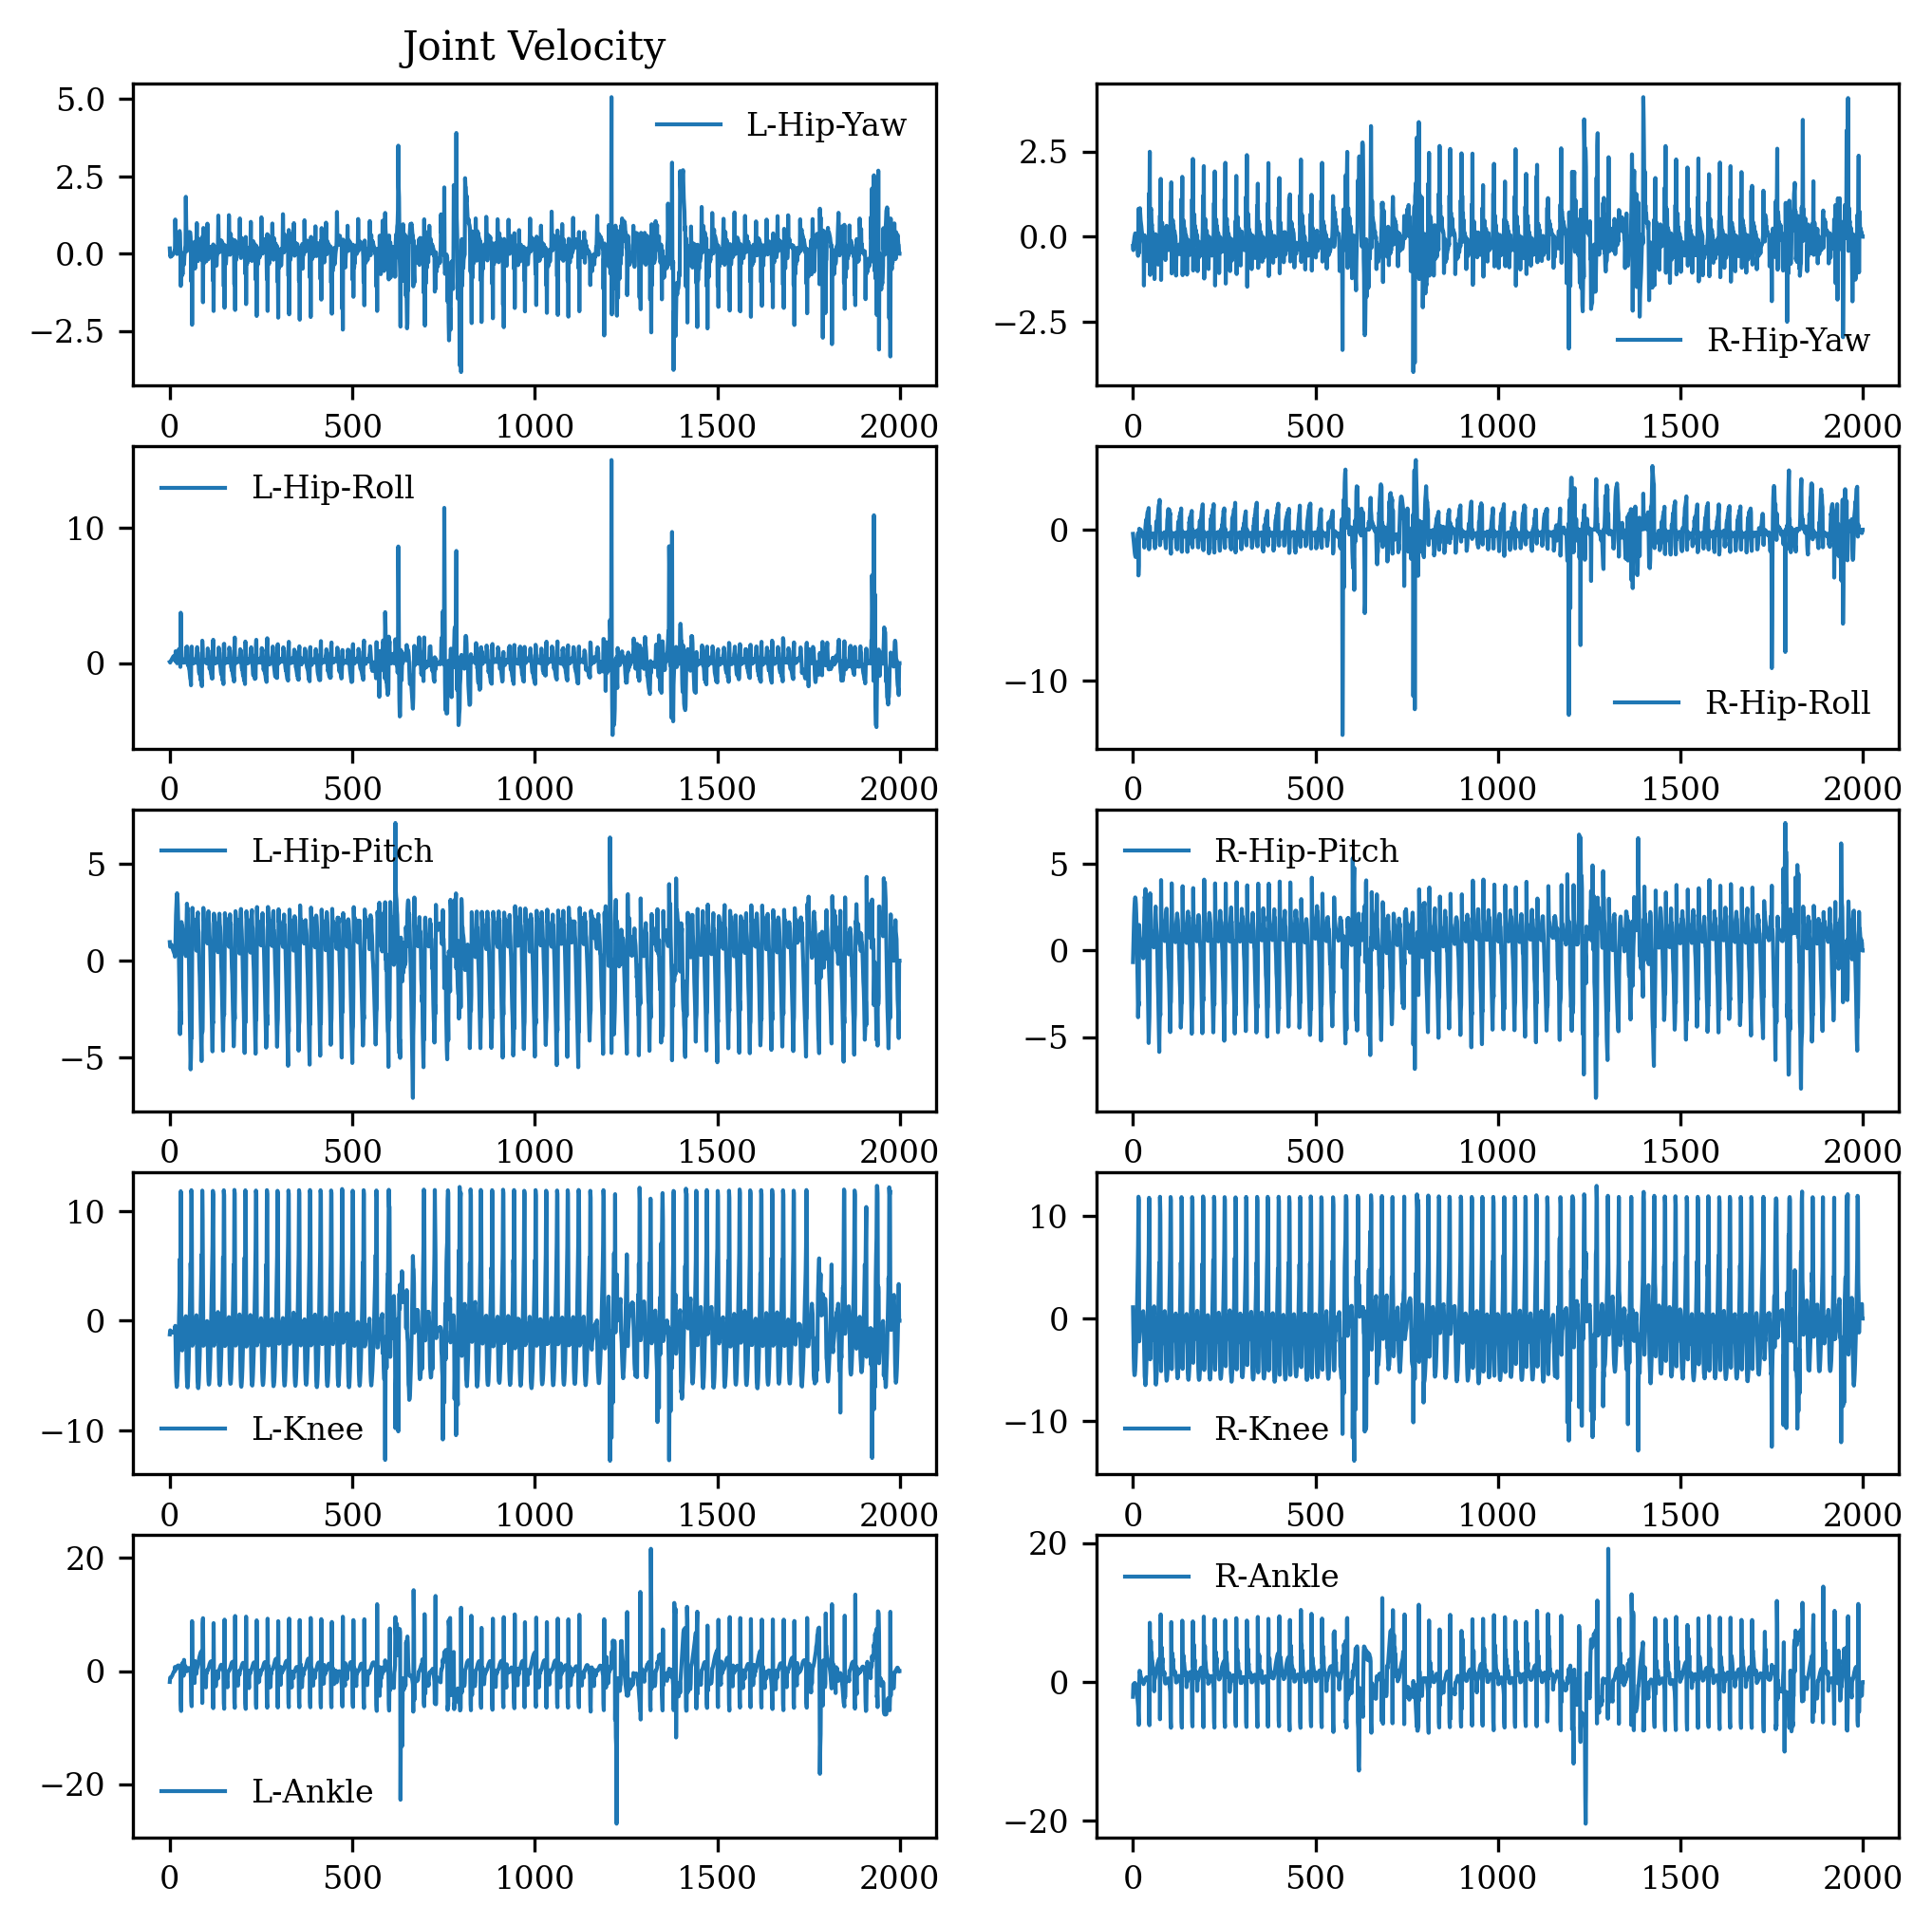

In [20]:
plt.figure(figsize=(8, 8))

plt.subplot(5, 2, 1)
plt.title("Joint Velocity")
plt.plot(joint_vel[0, :, 0], label="L-Hip-Yaw")
plt.legend()

plt.subplot(5, 2, 2)
plt.plot(joint_vel[0, :, 5], label="R-Hip-Yaw")
plt.legend()

plt.subplot(5, 2, 3)
plt.plot(joint_vel[0, :, 1], label="L-Hip-Roll")
plt.legend()

plt.subplot(5, 2, 4)
plt.plot(joint_vel[0, :, 6], label="R-Hip-Roll")
plt.legend()

plt.subplot(5, 2, 5)
plt.plot(joint_vel[0, :, 2], label="L-Hip-Pitch")
plt.legend()

plt.subplot(5, 2, 6)
plt.plot(joint_vel[0, :, 7], label="R-Hip-Pitch")
plt.legend()

plt.subplot(5, 2, 7)
plt.plot(joint_vel[0, :, 3], label="L-Knee")
plt.legend()

plt.subplot(5, 2, 8)
plt.plot(joint_vel[0, :, 8], label="R-Knee")
plt.legend()

plt.subplot(5, 2, 9)
plt.plot(joint_vel[0, :, 4], label="L-Ankle")
plt.legend()

plt.subplot(5, 2, 10)
plt.plot(joint_vel[0, :, 9], label="R-Ankle")
plt.legend()

plt.show()

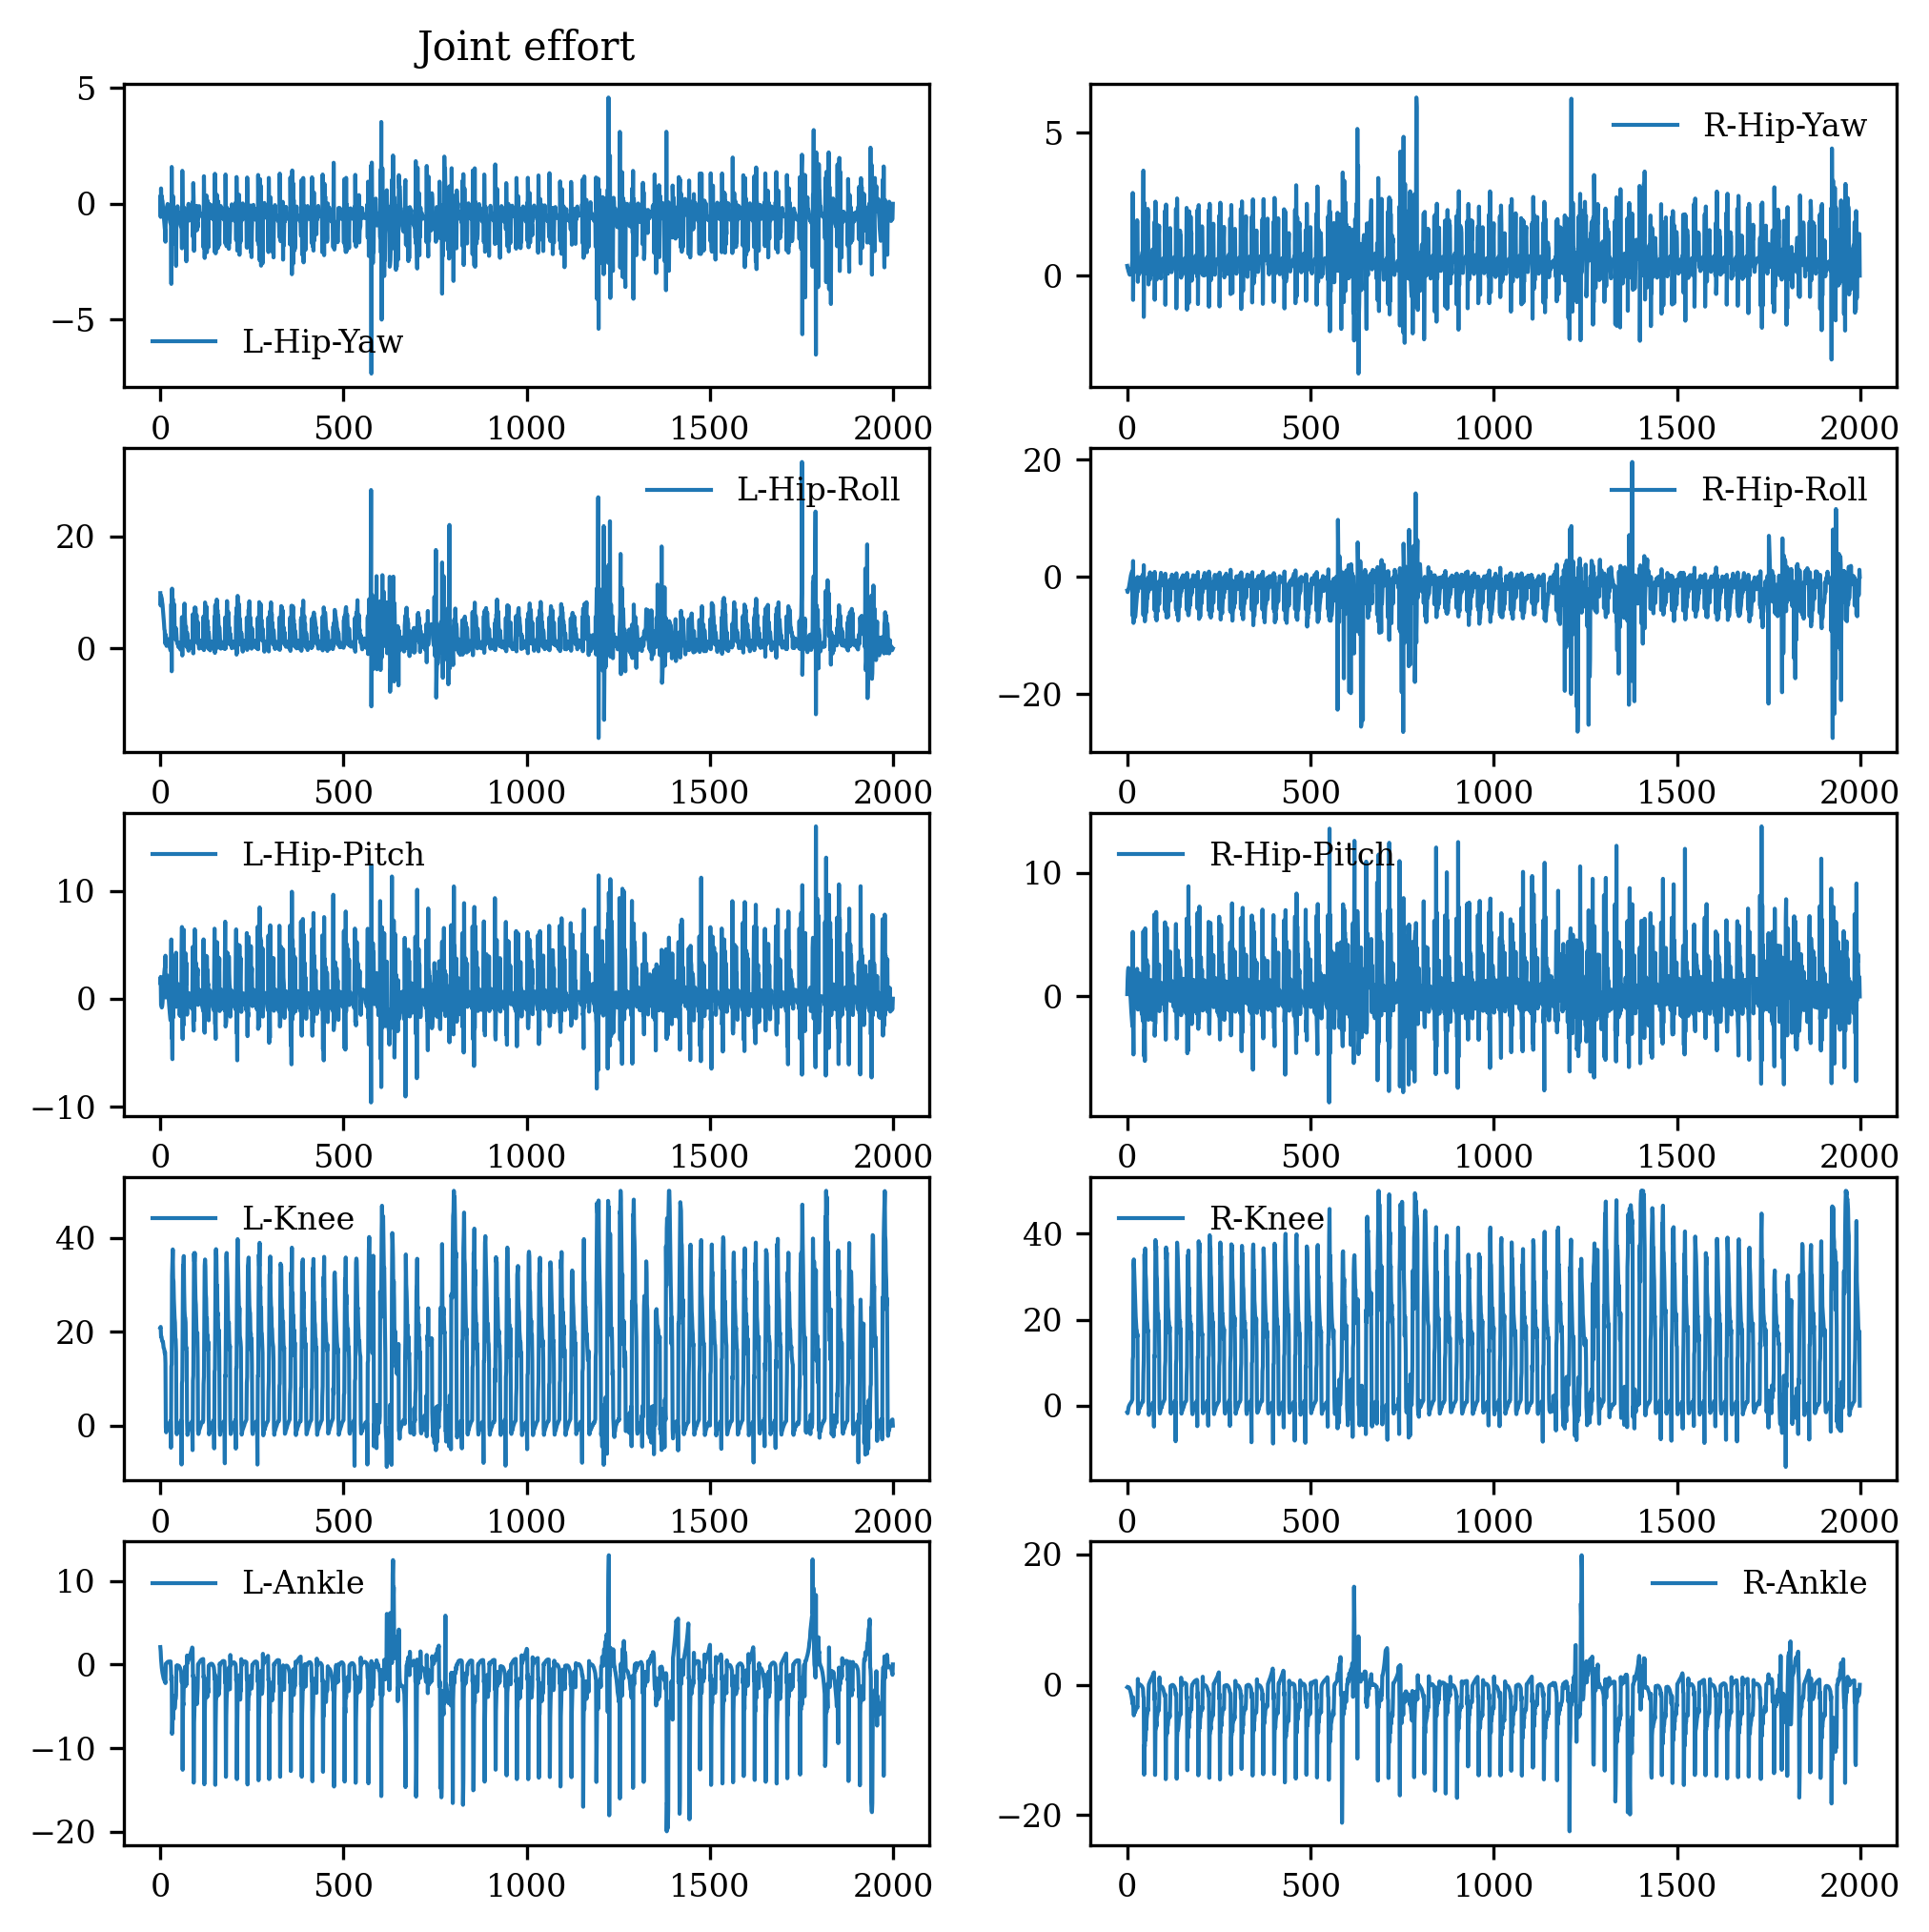

In [21]:
plt.figure(figsize=(8, 8))

plt.subplot(5, 2, 1)
plt.title("Joint effort")
plt.plot(joint_effort[0, :, 0], label="L-Hip-Yaw")
plt.legend()

plt.subplot(5, 2, 2)
plt.plot(joint_effort[0, :, 5], label="R-Hip-Yaw")
plt.legend()

plt.subplot(5, 2, 3)
plt.plot(joint_effort[0, :, 1], label="L-Hip-Roll")
plt.legend()

plt.subplot(5, 2, 4)
plt.plot(joint_effort[0, :, 6], label="R-Hip-Roll")
plt.legend()

plt.subplot(5, 2, 5)
plt.plot(joint_effort[0, :, 2], label="L-Hip-Pitch")
plt.legend()

plt.subplot(5, 2, 6)
plt.plot(joint_effort[0, :, 7], label="R-Hip-Pitch")
plt.legend()

plt.subplot(5, 2, 7)
plt.plot(joint_effort[0, :, 3], label="L-Knee")
plt.legend()

plt.subplot(5, 2, 8)
plt.plot(joint_effort[0, :, 8], label="R-Knee")
plt.legend()

plt.subplot(5, 2, 9)
plt.plot(joint_effort[0, :, 4], label="L-Ankle")
plt.legend()

plt.subplot(5, 2, 10)
plt.plot(joint_effort[0, :, 9], label="R-Ankle")
plt.legend()

plt.show()

## Tracking results

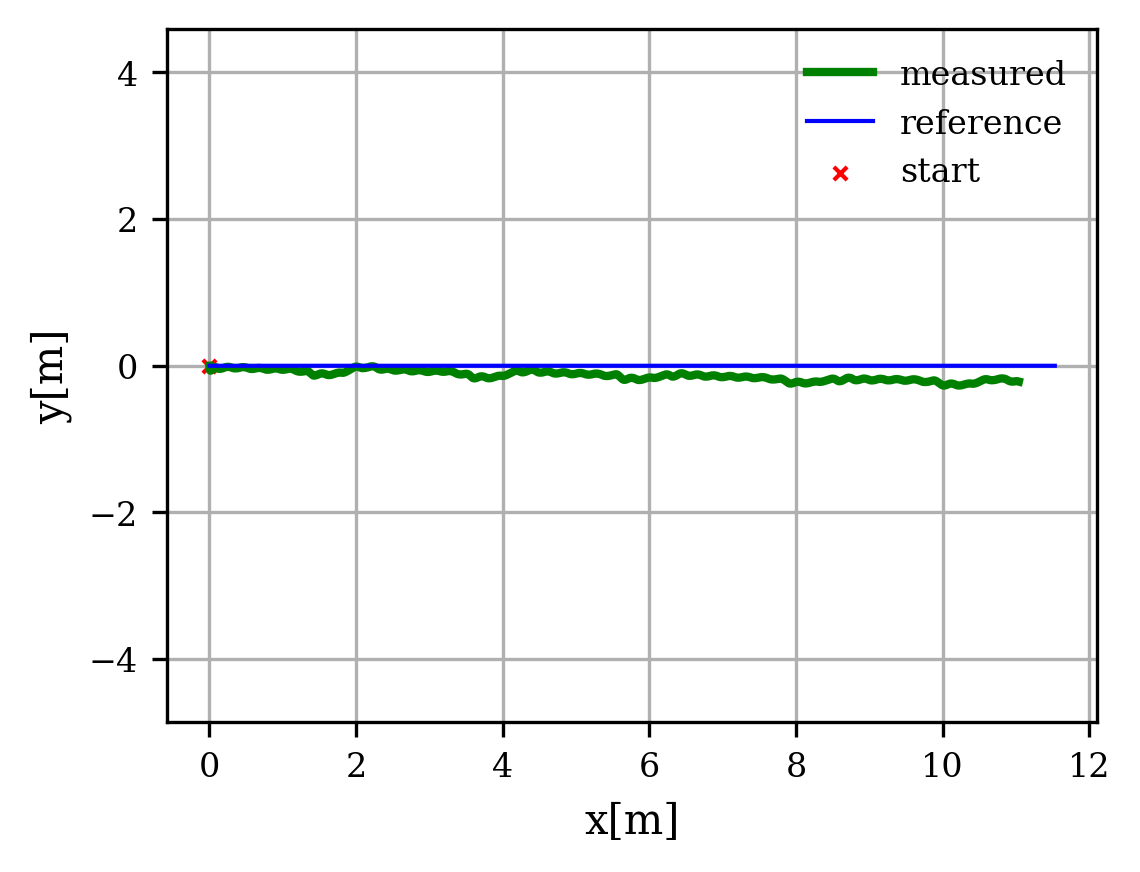

In [249]:
plt.figure(figsize=(4, 3))
num_sample = 1

for i in range(num_sample):
    t = (5 * 1/500) * np.arange(velocity_x[i].shape[0])
    pos = position[i]
    pos_des = position_des[i]
    
    pos_x = pos[:-1, 0]
    pos_y = pos[:-1, 1]
    pos_des_x = pos_des[:-1, 0]
    pos_des_y = pos_des[:-1, 1]
    
    plt.plot(pos_x, pos_y, label="measured", c="green", linewidth=2.0)
    plt.plot(pos_des_x, pos_des_y, label="reference", c="blue", linewidth=1.0)
    plt.scatter(pos_x[0], pos_y[0], c="red", label="start", s=10, marker="x")
    plt.xlabel("x[m]")
    plt.ylabel("y[m]")
    plt.grid()
    plt.axis("equal")
    plt.legend(loc="best")

# plt.savefig("trajectory_inf.png")
# plt.savefig("trajectory_circle.png")
plt.show()

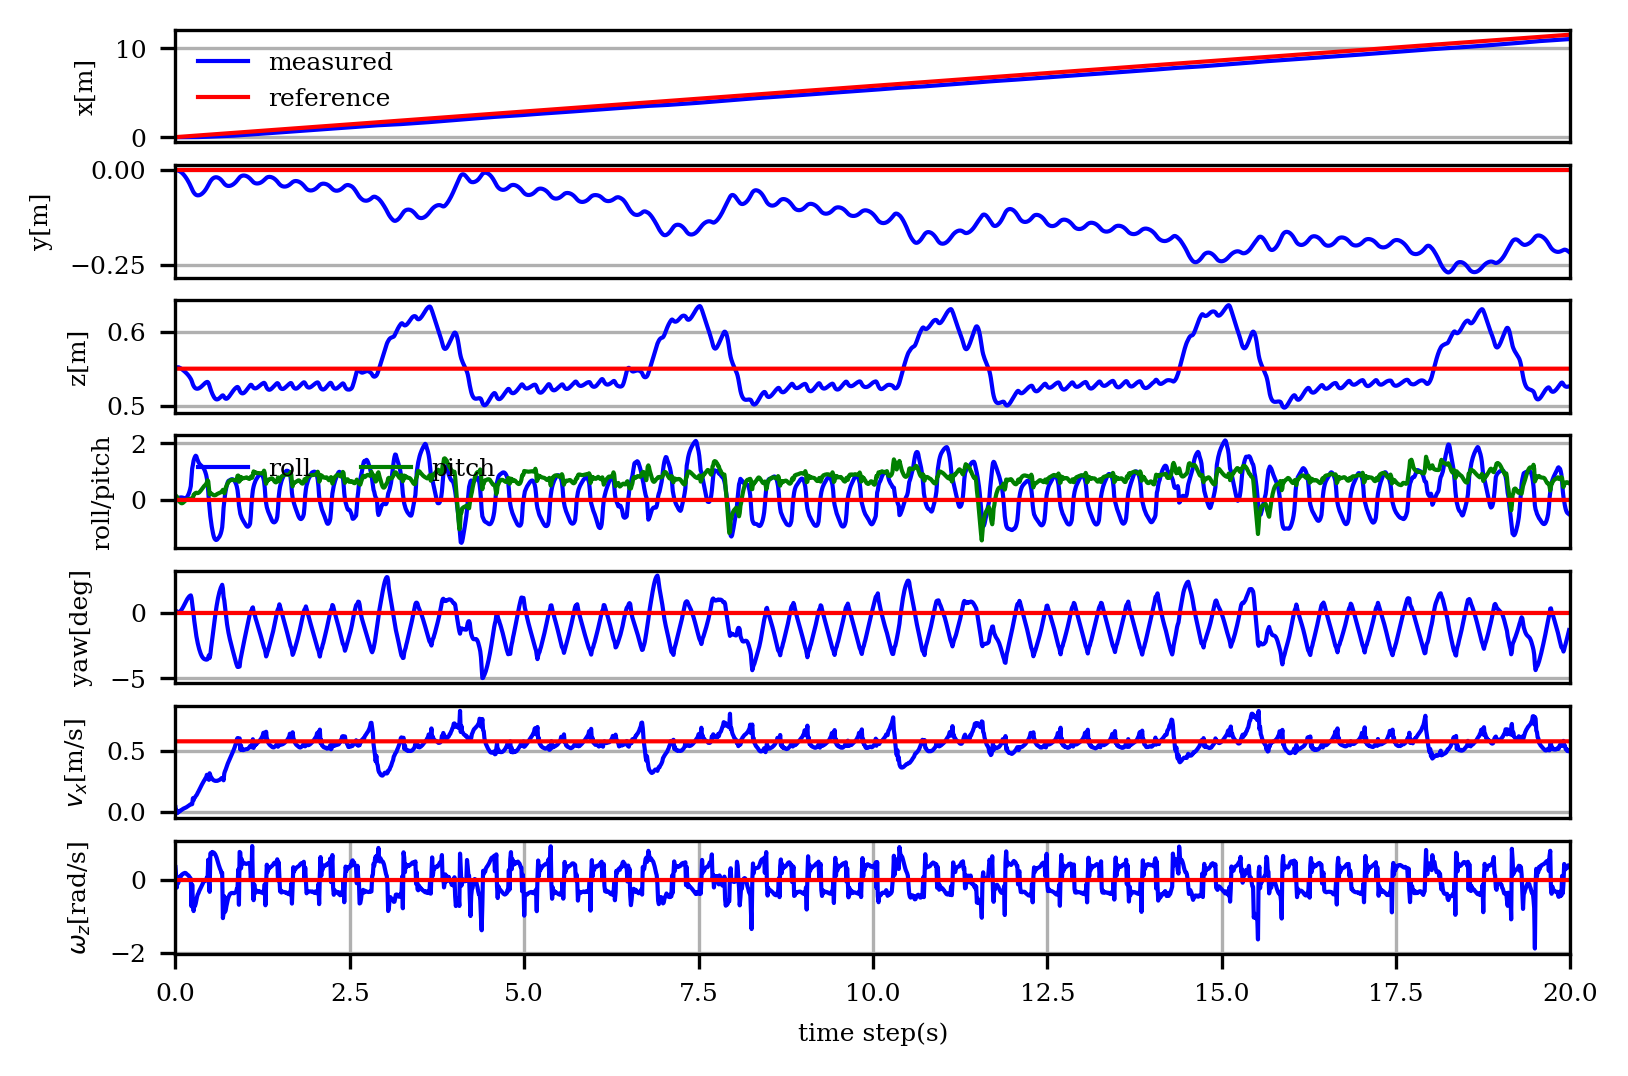

In [250]:

plt.figure(figsize=(6, 4))
num_sample = 1
# num_sample = len(velocity_x)

for i in range(num_sample):
    i = 0
    t = (5 * 1/500) * np.arange(velocity_x[i].shape[0])
    pos = position[i]
    orientation = euler[i]
    pos_x = pos[:, 0]
    pos_y = pos[:, 1]
    pos_z = pos[:, 2]
    roll = orientation[:, 0]
    pitch = orientation[:, 1]
    yaw = orientation[:, 2]
    
    plt.subplot(7, 1, 1)
    plt.plot(t[:-1], pos_x[:-1], label="measured", color="b")
    plt.plot(t[:-1], position_des[i, :-1, 0], label="reference", color="r")
    plt.ylabel("x[m]", fontsize=6)
    plt.xlim(0, np.max(t+0.01))
    plt.xticks([], fontsize=6)
    plt.yticks(fontsize=6)
    plt.legend(fontsize=6)
    plt.grid()
    
    plt.subplot(7, 1, 2)
    plt.plot(t[:-1], pos_y[:-1], label="y", color="b")
    plt.plot(t[:-1], position_des[i, :-1, 1], label="y_ref", color="r")
    plt.ylabel("y[m]", fontsize=6)
    plt.xlim(0, np.max(t+0.01))
    plt.xticks([], fontsize=6)
    plt.yticks(fontsize=6)
    plt.grid()
    
    plt.subplot(7, 1, 3)
    plt.plot(t[:-1], pos_z[:-1], label="z", color="b")
    plt.plot(t[:-1], position_des[i, :-1, 2], label="z_ref", color="r")
    plt.ylabel("z[m]", fontsize=6)
    plt.xlim(0, np.max(t+0.01))
    plt.xticks([], fontsize=6)
    plt.yticks(fontsize=6)
    plt.grid()
    
    plt.subplot(7, 1, 4)
    plt.plot(t[:-1], roll[:-1], label="roll", color="b")
    plt.plot(t[:-1], pitch[:-1], label="pitch", color="g")
    plt.plot(t[:-1], orientation_des[i, :-1, 0], color="r")
    plt.ylabel("roll/pitch", fontsize=6)
    plt.xlim(0, np.max(t+0.01))
    plt.xticks([], fontsize=6)
    plt.yticks(fontsize=6)
    plt.legend(fontsize=6, ncol=3)
    plt.grid()
    
    plt.subplot(7, 1, 5)
    plt.plot(t[:-1], yaw[:-1], label="yaw", color="b")
    plt.plot(t[:-1], orientation_des[i, :-1, 2], label="yaw_ref", color="r")
    plt.ylabel("yaw[deg]", fontsize=6)
    plt.xlim(0, np.max(t+0.01))
    plt.xticks([], fontsize=6)
    plt.yticks(fontsize=6)
    plt.grid()
    
    plt.subplot(7, 1, 6)
    plt.plot(t[:-1], velocity_x[i, :-1], label="actual", color="b")
    plt.plot(t[:-1], desired_velocity_x[i,:-1], label="desired", color="r")
    plt.ylabel(r"$v_x$[m/s]", fontsize=6)
    plt.xlim(0, np.max(t+0.01))
    plt.xticks([], fontsize=6)
    plt.yticks(fontsize=6)
    plt.grid()
    
    plt.subplot(7, 1, 7)
    plt.plot(t[:-1], ang_velocity[i, :-1, -1], label="actual", color="b")
    plt.plot(t[:-1], desired_ang_velocity[i,:-1], label="desired", color="r")
    plt.ylabel(r"$\omega_z$[rad/s]", fontsize=6)
    plt.xlim(0, np.max(t+0.01))
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.grid()

plt.xlabel("time step(s)", fontsize=6)
plt.savefig("tracking.png")
plt.show()